This notebook trains an autoencoder on synthetic documents produced from the first 1e8 bytes of Wikipedia.

In [1]:
# https://github.com/ipython/ipykernel/issues/111
# Create logger
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
import sys # create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)-15s : %(levelname)s : %(message)s') # - %(name)s %(clientip)s %(user)-8s
handler.setFormatter(formatter) # create formatter and add it to the handler
logger.handlers = [handler] # set STDERR handler as the only handler
logging.info('begin')

2017-04-21 12:34:29,670 : INFO : begin


In [2]:
import numpy as np
from scipy.stats import skew  # surprising this isn't in numpy
import tensorflow as tf
import matplotlib.pyplot as plt
from importlib import reload
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)

In [3]:
# major inputs to this notebook
AGGREGATE_OOV = False  # skip out of vocabulary words when computing aggregate word counts (or softhots)
NUM_DOCUMENTS = 200  # generate (at most) this many documents...
MEAN_DOC_SIZE = 300  # ...of this average size (log normal distribution; at size 300/380 only about 18441/14605 docs can be generated from text8.zip)
NUM_EPOCHS = 100  # number of training epochs
VOCAB_MAGNITUDE = 5000  # size of vocabulary

## Vocabulary Construction

In [4]:
import os
import json
#from nltk.stem import LancasterStemmer # http://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg
from tfae.nlputils import corpus_stemmer
from tfae.nlputils import doc
reload(corpus_stemmer)
reload(doc)

# count the number of occurrences of each word in text8.zip
zipfile = 'text8'
zippath = os.path.join(os.getcwd(), 'data', 'word2vec_data', zipfile + '.zip')  # Linux
if not os.path.isfile(zippath):
    zippath = os.path.join(os.getcwd(), '..', 'word2vec', 'data', zipfile + '.zip')  # Windows
doc_factory = doc.DocumentFactory(zippath, zipfile)

try:
    stemmer = corpus_stemmer.CorpusStemmer.load()
except (FileNotFoundError, json.JSONDecodeError):
    logging.debug('Unable to load CorpusStemmer from file {}; constructing from wordcounts instead'.format(corpus_stemmer.CorpusStemmer._SERIALIZE_FILENAME))

    # get raw, unadulterated (i.e. no stemming and no stopwords) wordcounts
    cw = doc_factory.count_words(stemmer=None, is_stopword_pred=lambda w: False)
    unstemmed_wordcounts = cw[0]

    # former todo comment from below: Probably should scrap usage of SoftHot after CorpusStemmer is
    # introduced--or at least make it configurable to switch back and forth between SoftHot and BoW,
    # which it now is (see word_count_vectorizers)
    stemmer = corpus_stemmer.CorpusStemmer(unstemmed_wordcounts)
    stemmer.dump()

2017-04-21 12:34:32,520 : INFO : tf_autoencoder imported
2017-04-21 12:34:33,335 : DEBUG : Loading CorpusStemmer from file /home/fred/code/tf_autoencoder/tfae/nlputils/resources/corpus_stemmer.pkl
2017-04-21 12:34:34,384 : DEBUG : Done loading CorpusStemmer (should take around 1 s)


In [5]:
logging.debug('begin')
import pickle

# a few (6) of the constant stopwords map to the same stem
stemmed_constant_stopwords = set(stemmer.stem(w) for w in doc.STOPWORDS)
is_stopword_ntbk = lambda w: w in stemmed_constant_stopwords or stemmer.is_stopword(w, is_token_stemmed=True)

# re-count words with the stemmer
fname = 'data/20170307-SemanticSearch-count_words.pkl'
if os.path.isfile(fname):
    with open(fname, 'rb') as f:
        logging.debug('Loading {}'.format(fname))
        cw = pickle.load(f)
else:
    logging.debug('Processing and dumping to {}'.format(fname))
    cw = doc_factory.count_words(stemmer=stemmer, is_stopword_pred=is_stopword_ntbk)  # ~19 seconds in nosetests
    with open(fname, 'wb') as f:
        pickle.dump(cw, f)
        
wordcounts, nwords, nwords_norepeat, nwords_nostops = cw
assert('classified' not in wordcounts)

# 17,005,207 words in text8.zip (253,854 unique, 16,794,078 w/out consecutive repeats)
print('zippath = {}'.format(zippath))
print('nwords = {}, nwords_norepeat = {}, nwords_nostops = {}, nunique = {}'.format(nwords, nwords_norepeat, nwords_nostops, len(wordcounts)))
for w in ('', 'the', 'has', 'anarchy', 'anarchism', 'cdq', 'pattern', 'society', 'classified'):
    stemmed = stemmer.stem(w)
    print('count({}/{}) = {}'.format(w, stemmed, wordcounts[stemmed] if stemmed in wordcounts else 0))
logging.debug('end')

2017-04-21 12:34:34,403 : DEBUG : begin
2017-04-21 12:34:34,406 : DEBUG : Loading 20170307-SemanticSearch-count_words.pkl
2017-04-21 12:34:34,637 : DEBUG : end


zippath = /home/fred/Documents/code/notebooks/data/word2vec_data/text8.zip
nwords = 16789212, nwords_norepeat = 17005207, nwords_nostops = 8552136, nunique = 156322
count(/) = 0
count(the/the) = 1061368
count(has/ha) = 38205
count(anarchy/anarc) = 1276
count(anarchism/anarc) = 1276
count(cdq/cdq) = 1
count(pattern/patern) = 1860
count(society/societi) = 4889
count(classified/clasif) = 1853


In [6]:
print(stemmer.stem('classified'))
print(wordcounts.get(stemmer.stem('classified'), None))  # <- should be 1853
print(wordcounts.get('classified', None))  # <- should be None

clasif
1853
None


In [7]:
vocab, sortedcounts = doc.DocumentFactory.construct_vocabulary(VOCAB_MAGNITUDE, wordcounts,
                                                               is_stopword_pred=is_stopword_ntbk)

print('top vocab:\n  {}\n'.format([(w, int(1/invc)) for invc, w  in sortedcounts[:15]]))
print('bottom vocab:\n  {}\n'.format([(w, int(1/invc)) for invc, w  in sortedcounts[VOCAB_MAGNITUDE-5:VOCAB_MAGNITUDE]]))

# a few (6) of the constant stopwords map to the same stem
print('Number of (unstemmed) constant stopwords: {}'.format(len(doc.STOPWORDS)))
print('Number of (stemmed) constant stopwords: {}'.format(len(stemmed_constant_stopwords)))
print('Number of (stemmed) constant stopwords in wordcounts: {} (should be the same)'.format(len([w for w in wordcounts.keys() if w in stemmed_constant_stopwords])))
print('Number of (stemmed) stemmer stopwords in wordcounts: {} (should be {})'.format(len([w for w in wordcounts.keys() if stemmer.is_stopword(w, is_token_stemmed=True)]), corpus_stemmer.CorpusStemmer.N_STOPWORDS))
print('Number of (stemmed) unioned stopwords in wordcounts: {}'.format(sum(1 for w in wordcounts.keys() if is_stopword_ntbk(w))))

top vocab:
  [('th', 13385), ('throu', 13250), ('later', 13002), ('state', 12923), ('histori', 12828), ('countri', 12706), ('governm', 12697), ('group', 12569), ('being', 12552), ('up', 12548), ('god', 12504), ('develo', 12301), ('high', 12238), ('centur', 12166), ('large', 12115)]

bottom vocab:
  [('repli', 261), ('silico', 261), ('ascen', 260), ('baco', 260), ('cher', 260)]

Number of (unstemmed) constant stopwords: 122
Number of (stemmed) constant stopwords: 116
Number of (stemmed) constant stopwords in wordcounts: 116 (should be the same)
Number of (stemmed) stemmer stopwords in wordcounts: 100 (should be 100)
Number of (stemmed) unioned stopwords in wordcounts: 158


In [8]:
# 'th' probably shows up as a word b/c it often gets an apostrophe before it, or maybe it's just 'the' misspelled
try:
    for w, c in unstemmed_wordcounts.items():
        if stemmer.stem(w) == 'th':
            print(w, c)
except NameError:
    pass  # unstemmed_wordcounts not defined
for unstemmed, node in stemmer._vocab.items():
    if node.prefix == 'th':
        print(node.tostr(-1, stemmer._prefix2word))
print('is_stopword("th") = {}'.format(stemmer.is_stopword('th', is_token_stemmed=True)))

-1 th 13385
  ['th', 'ths', 'tth']
is_stopword("th") = False


## Document Vectorization

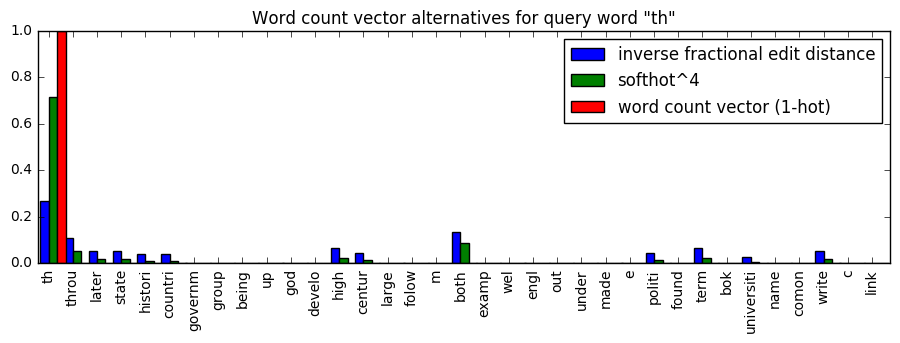

In [9]:
from tfae.nlputils import vectorizer
reload(vectorizer)
query = vocab[0]  # words in the vocab have already been stemmed
n = 35
exponent = 4

softhotter = vectorizer.SoftHot(vocab[:n], is_stopword_pred=doc.DEFAULT_IS_STOPWORD_PRED) # lambda w: False) <- same
softhots = softhotter.eval(query, exponent=exponent)
onehots = vectorizer.WordCountVectorizer(vocab[:n]).eval(query)

# normalize similarities to sum to 1 also (for plotting purposes only)
softhotter._similarities = softhotter._similarities / np.sum(softhotter._similarities)

# plot
fig, ax = plt.subplots(1, 1, figsize=(11, 3))
width = 0.35
x = np.arange(n)
ax.bar(x, softhotter._similarities, width, color='b', label='inverse fractional edit distance')
ax.bar(x +   width,   softhots    , width, color='g', label='softhot^{}'.format(exponent))
ax.bar(x + 2*width,    onehots    , width, color='r', label='word count vector (1-hot)')
ax.set_title('Word count vector alternatives for query word "{}"'.format(query));
ax.xaxis.set_ticks(x + width)
ax.set_xticklabels(vocab[:n], rotation='vertical');
ax.legend()
ax.set_xlim(-0.1, n + 0.1);

In [10]:
reload(vectorizer)

# softhot-computing functor OR just use WordCountVectorizer
#word_count_vectorizer = vectorizer.SoftHot(vocab)  # softhot probably not such a good idea now that using a stemmer
word_count_vectorizer = vectorizer.WordCountVectorizer(vocab)
mincount = int(1/sortedcounts[VOCAB_MAGNITUDE-1][0])
agg_wc_vec = word_count_vectorizer.aggregate(wordcounts, logging_words={'cdq', vocab[0]})



# TODO: generate `agg_wc_vec` using TensorFlow so that `doccounts` and `idf1` computations can be corrected



print('word_count_vectorizer.vmag = {}'.format(word_count_vectorizer.vmag))
print('final agg_wc_vec: mean = {:.3f}, stdev = {:.2f}, 25th/median/75th = {:.1f}/{:.1f}/{:.1f}'.format(np.mean(agg_wc_vec), np.std(agg_wc_vec), np.percentile(agg_wc_vec, 25), np.median(agg_wc_vec), np.percentile(agg_wc_vec, 75)))
relcounts = [1/sc[0]/agg_wc_vec[i] for i, sc in enumerate(sortedcounts[:VOCAB_MAGNITUDE])]
print('final relcounts: mean = {:.3f}, median = {:.3f}, stdev = {:.3f}'.format(np.mean(relcounts), np.median(relcounts), np.std(relcounts)))
print('selected old/new counts:')
for i in (0, 1, 2, VOCAB_MAGNITUDE-3, VOCAB_MAGNITUDE-2, VOCAB_MAGNITUDE-1):
    sc = sortedcounts[i]
    awv = agg_wc_vec[i]  # these should all be 1 when using wordcount vecs, but not when using softhots
    print('  [{}]({}) = {}/{:.3f} = {:.3f}'.format(i, sc[1], int(1/sc[0]), awv, 1/sc[0]/awv))

2017-04-21 12:34:46,014 : DEBUG : query word (12232) = "th"
2017-04-21 12:34:46,016 : DEBUG :   vec[:10] = [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] (sum = 1.0)
2017-04-21 12:34:46,017 : DEBUG :   mean = 0.0002, median = 0.0, stdev = 0.014140721339450825
2017-04-21 12:34:46,017 : DEBUG :   max = 1.0, argmax = "th"
2017-04-21 12:34:47,868 : DEBUG : query word (142430) = "cdq"
2017-04-21 12:34:47,869 : DEBUG :   vec[:10] = [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] (sum = 0.0)
2017-04-21 12:34:47,869 : DEBUG :   mean = 0.0, median = 0.0, stdev = 0.0
2017-04-21 12:34:47,870 : DEBUG :   max = 0.0, argmax = "th"


word_count_vectorizer.vmag = 5000
final agg_wc_vec: mean = 1412.138, stdev = 1820.63, 25th/median/75th = 400.0/720.0/1595.2
final relcounts: mean = 1.000, median = 1.000, stdev = 0.000
selected old/new counts:
  [0](th) = 13385/13385.000 = 1.000
  [1](throu) = 13250/13250.000 = 1.000
  [2](later) = 13002/13002.000 = 1.000
  [4997](ascen) = 260/260.000 = 1.000
  [4998](baco) = 260/260.000 = 1.000
  [4999](cher) = 260/260.000 = 1.000


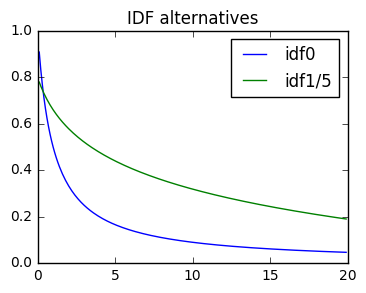

In [11]:
# http://www.benfrederickson.com/distance-metrics/
# N = len(docs)
# idf = [1. + log(N / (1. + p)) for p in data.groupby('wordid').size()]
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.set_title('IDF alternatives')
maxx = 20  # at most a word can appear in every document, this is `maxx`
x = np.arange(0.1, maxx, 0.1)
ax.plot(x, 1 / (1.0 + x), label='idf0');
ax.plot(x, (1.0 + np.log(maxx / (1.0 + x))) / 5, label='idf1/5');
ax.legend();

In [12]:
# test construction of just 2 documents, about 4 words each
r = doc_factory.construct_docs(2, word_count_vectorizer,
                               avgsz=np.log(4), stdsz=0, stemmer=stemmer)

def doctext2stopcount(doctext):
    """Prints enhanced document text, original words, their stems, whether or not they
    are stopwords or OOV, and their count according to the stemmer.
    """
    str = ''
    for w in doctext.split():
        stemmed = stemmer.stem(w)
        in_vocab = word_count_vectorizer.in_vocab(stemmed)
        stopstr = 'STOP' if is_stopword_ntbk(stemmed) else 'OOV' if not in_vocab else ''
        str += ' {}/{}/{}/{}'.format(w, stemmed, stopstr, stemmer.corpus_count(w))
    return str

for i in range(2):
    print('i={}, wordcount={}, doctext="{}"'.format(i, dict(r[1][i]), r[2][i]))
    print(' {}\n'.format(doctext2stopcount(r[2][i])))

2017-04-21 12:34:48,240 : INFO : First 10 docsizes (out of 2): [4, 4]


i=0, wordcount={'anarc': 1, 'origina': 1, 'term': 1, 'abus': 1}, doctext=" anarchism originated as a term of abuse"
  anarchism/anarc//1287 originated/origina//1102 as/as/STOP/131889 a/a/STOP/325801 term/term//11209 of/of/STOP/598145 abuse/abus//928

i=1, wordcount={'agains': 1, 'clas': 1, 'engl': 1, 'radica': 1}, doctext=" first used against early working class radicals including the diggers of the english"
  first/first/STOP/28886 used/used/STOP/22738 against/agains//8432 early/earli/STOP/13583 working/work/STOP/17947 class/clas//4663 radicals/radica//1041 including/includ/STOP/21948 the/the/STOP/1061370 diggers/dige/OOV/58 of/of/STOP/598145 the/the/STOP/1061370 english/engl//11861



In [13]:
# normalize each document's (softhot-based) BM25 vector s.t. this percentile is equal to
# 1.0 (used in assorted log messages; probably best to use with softhot inputs)
# note that this is a percentile of the vocabulary size, so it is effectively the same as
# NORM_NEG_PARTITION_IDX = 0.005 * VOCAB_MAGNITUDE (e.g. 0.005 * 3000 = 15)
NORM_PERCENTILE = 99.5

# normalize based on this percentile of the non-zero values only (allows for documents with lots of
# repeated words to still stand out, while at the same time controls for document size)
NORM_NONZERO_PERCENTILE = 50

# normalize each document's wordcount vector s.t. the second largest value is equal to 1.0,
# this value gets negated in `nth_largest` below, which is why -2 corresponds to the second largest
NORM_NEG_PARTITION_IDX = 2

# normalization strategy
from enum import Enum#, auto # auto not introduced until Python 3.6
class NormStrategy(Enum):
    NONE = 0#auto()         # X - certainly doesn't work, no improvement in loss other than after first epoch
    PERCENTILE = 1          # d - works with softhots and with wordcounts if doc sizes are big enough
    NONZERO_PERCENTILE = 2  # X - same issue as with `NONE`
    INDEX = 3               # d - seems like it might work okay
    SUM = 4                 # X - same issue as with `NONE`
    
# whatever normalization strategy is chosen, it seems like the values need to *approximately*
# end up between 0 and 1 for the VAE to function properly (TODO: figure out why this is)
NORM_STRATEGY = NormStrategy.PERCENTILE

In [14]:
# define some functions used in the following cells
def nth_largest(v, n=NORM_NEG_PARTITION_IDX):
    v = np.array(v)  # v might be a list
    return np.partition(v.flatten(), -n)[-n]

def stats_str(v, dfmt='{:.3f}', print_argmax=True):
    vfmt = 'mean=' + dfmt + ', stdev=' + dfmt + ', skew=' + dfmt + ', 25th/median/75th/95th/{}th percentiles=' + dfmt + '/' + dfmt + '/' + dfmt + '/' + dfmt + '/' + dfmt + ', {}th largest=' + dfmt + ', max=' + dfmt + ', argmax="{}"'    
    return vfmt.format(np.mean(v), np.std(v), skew(v), NORM_PERCENTILE, np.percentile(v, 25), np.median(v), np.percentile(v, 75), np.percentile(v, 95), np.percentile(v, NORM_PERCENTILE), NORM_NEG_PARTITION_IDX, nth_largest(v), np.max(v), vocab[np.argmax(v)] if print_argmax else 'N/A')

2017-04-21 12:34:48,545 : INFO : First 10 docsizes (out of 1): [299]


w[1513]="label"        , count= 2, wc_vec= 2.0, idf0e2=23.1, idf1=10.3, tfidf=14.5, bm25=13.2
w[2762]="piere"        , count= 2, wc_vec= 2.0, idf0e2=48.3, idf1=10.8, tfidf=15.3, bm25=13.9
w[1323]="justic"       , count= 1, wc_vec= 1.0, idf0e2=20.0, idf1=10.1, tfidf=10.1, bm25=10.1
w[ 125]="refer"        , count= 1, wc_vec= 1.0, idf0e2= 4.2, idf1= 8.7, tfidf= 8.7, bm25= 8.7
w[ 699]="belie"        , count= 1, wc_vec= 1.0, idf0e2=11.5, idf1= 9.7, tfidf= 9.7, bm25= 9.7
w[ 483]="china"        , count= 1, wc_vec= 1.0, idf0e2= 8.8, idf1= 9.4, tfidf= 9.4, bm25= 9.4
w[ 571]="taken"        , count= 1, wc_vec= 1.0, idf0e2= 9.8, idf1= 9.5, tfidf= 9.5, bm25= 9.5
w[ 825]="broug"        , count= 1, wc_vec= 1.0, idf0e2=13.2, idf1= 9.8, tfidf= 9.8, bm25= 9.8
w[ 198]="believ"       , count= 2, wc_vec= 2.0, idf0e2= 5.3, idf1= 8.9, tfidf=12.6, bm25=11.5
w[ 919]="aid"          , count= 1, wc_vec= 1.0, idf0e2=14.4, idf1= 9.9, tfidf= 9.9, bm25= 9.9

document word count vector: mean=0.060, stdev=0.491, skew=3

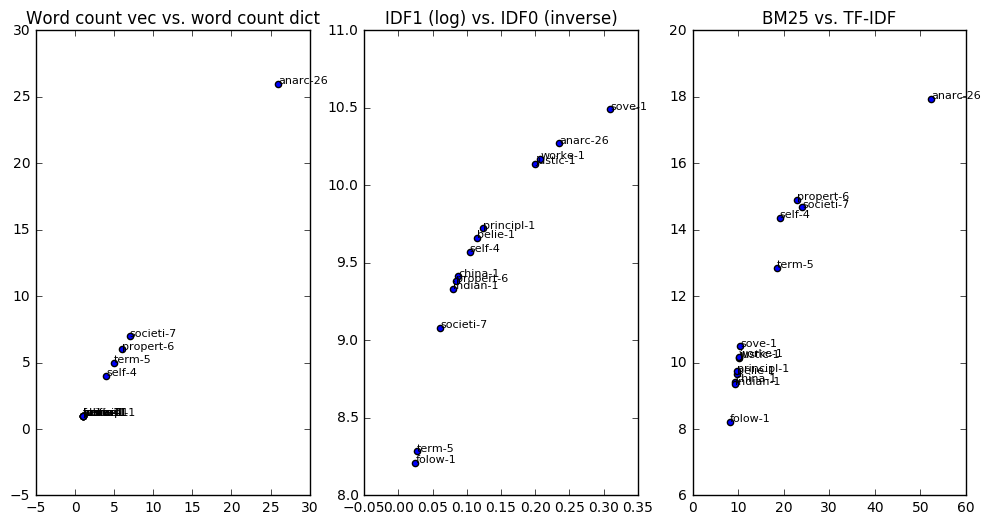

In [15]:
from tfae.nlputils import weights
from tfae.nlputils import plot
reload(weights)
reload(plot)

# every `docsize` (300) words is a new document? should probably randomize this
# so that higher priority is given to longer docs (per the `B` arg to bm25_weight)
docsize = MEAN_DOC_SIZE # 3
adoc = doc_factory.construct_docs(1, word_count_vectorizer,
                                  avgsz=np.log(docsize), stdsz=0, stemmer=stemmer)
doc_wc_vec, docwordcounts = adoc[0][0], adoc[1][0]

# un-scale?
#doc_wc_vec *= max(docwordcounts.values())

# calculate IDF for each word
idf1_ndocs = nwords / docsize  # number of documents for idf1 purposes
doccounts = agg_wc_vec / docsize  # agg_wc_vec ignores docs, so divide by docsize to get approx. doc count
idf0 = np.where(doccounts == 0, 1.0, 1.0 / doccounts)  # if you use agg_wc_vec here rather than doccounts then idf1 can go negative
idf1 = 1.0 + np.log(idf1_ndocs / (1.0 + doccounts))

# 2 different ways to compute document-word weights
doctfidfs = weights.tfidf_weight(doc_wc_vec, idf1)
docbm25s = weights.bm25_weight(doc_wc_vec, idf1, docsize, B=0.5, K1=0.8)  # before scaling in construct_docs: B=0.5, K1=0.8
# NOTE: docbm25s are not normalized

for j, (w, c) in enumerate(docwordcounts.items()):
    try: i = vocab.index(w)
    except: print('w[----]={:15s}, count={:2d}, {}'.format('"'+w+'"', c, '<STOPWORD>' if is_stopword_ntbk(w) else '<OOV>'))
    else: print('w[{:4d}]={:15s}, count={:2d}, wc_vec={:4.1f}, idf0e2={:4.1f}, idf1={:4.1f}, tfidf={:4.1f}, bm25={:4.1f}'.format(i, '"'+w+'"', c, doc_wc_vec[i], idf0[i]*1e2, idf1[i], doctfidfs[i], docbm25s[i]))
    if j > 8: break

print('\ndocument word count vector: {}\n'.format(stats_str(doc_wc_vec)))

# the effect of the last plot was much more obvious when stop words were included (they
# fell below the trendline)
plot.plot_document(vocab, idf0, idf1, doc_wc_vec, docwordcounts, doctfidfs, docbm25s)

In [16]:
from tfae import vae
from tfae import train
from tfae.nlputils import tfidf

In [17]:
# it takes about 1.5 minutes to construct 200 documents of 300 words each (6 minutes for 800)
logging.info('begin')

# set lower_bound_size (only required when testing with a small MEAN_DOC_SIZE)
if NORM_STRATEGY == NormStrategy.PERCENTILE:
    pct_required = 100 - NORM_PERCENTILE
    lower_bound_size = int(pct_required / 100 * VOCAB_MAGNITUDE + 0.5)
elif NORM_STRATEGY == NormStrategy.NONZERO_PERCENTILE:
    lower_bound_size = 4
elif NORM_STRATEGY == NormStrategy.INDEX:
    lower_bound_size = NORM_NEG_PARTITION_IDX * 6
elif NORM_STRATEGY == NormStrategy.SUM:
    lower_bound_size = 20
elif NORM_STRATEGY == NormStrategy.NONE:
    lower_bound_size = 1
else:
    raise ValueError('Unknown NORM_STRATEGY='.format(NORM_STRATEGY))
    
# TODO: why not just normalize by docsize?  or wouldn't this be the same as normalizing the
# length of the vector to sum to 1
print('lower_bound_size: {}'.format(lower_bound_size))
print('MEAN_DOC_SIZE: {}'.format(MEAN_DOC_SIZE))

# as of 3/9/17 English Wikipedia has 5,350,632 articles and 2.9 billion words => mean=542,
# and median=280/416*542=365 perhaps (based on lognormal dist w/ mean 416 and median 280)
wc_vecs, wcs, dts = doc_factory.construct_docs(NUM_DOCUMENTS, word_count_vectorizer,
                                                     avgsz=np.log(MEAN_DOC_SIZE), stdsz=0.7, lbsz=lower_bound_size,
                                                     stemmer=stemmer)#,
                                                     #outpath=os.path.join(os.getcwd(), 'data'))

2017-04-21 12:34:49,620 : INFO : begin
2017-04-21 12:34:49,621 : INFO : Clipping 0 document size(s) to minimum of 25
2017-04-21 12:34:49,622 : INFO : First 10 docsizes (out of 200): [1031  396  595 1440 1108  151  583  269  279  399]


lower_bound_size: 25
MEAN_DOC_SIZE: 300


In [18]:
docsizes = np.array([np.sum(v) for v in wc_vecs])
median_docsize = np.median(docsizes)
print('first 10 docsizes (shuffled? except for first): {}'.format(docsizes[:10]))
print('docsizes: {}\n'.format(stats_str(docsizes, dfmt='{:.0f}', print_argmax=False)))

# lru_cache stats
# CacheInfo(hits=36359, misses=25848, maxsize=256, currsize=256) with NUM_DOCUMENTS=200 and avgsz=log(300)
print(word_count_vectorizer.eval.cache_info(), '\n')

first = wc_vecs[0]
print('first word count vec: {}\n'.format(stats_str(first)))
print('aggregate wc vec: {}\n'.format(stats_str(agg_wc_vec, dfmt='{:.0f}')))
logging.info('end')

2017-04-21 12:35:10,948 : INFO : end


first 10 docsizes (shuffled? except for first): [ 1031.   396.   595.  1440.  1108.   151.   583.   269.   279.   399.]
docsizes: mean=406, stdev=309, skew=2, 25th/median/75th/95th/99.5th percentiles=182/312/528/1121/1470, 2th largest=1469, max=1590, argmax="N/A"

CacheInfo(hits=14173, misses=190232, maxsize=512, currsize=512) 

first word count vec: mean=0.206, stdev=1.274, skew=32.594, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/1.000/5.005, 2th largest=16.000, max=68.000, argmax="anarc"

aggregate wc vec: mean=1412, stdev=1821, skew=3, 25th/median/75th/95th/99.5th percentiles=400/720/1595/5026/11261, 2th largest=13250, max=13385, argmax="th"



In [19]:
def construct_bm25_normalizer(bm25s):
    """Construct the BM25 normalizer and confirm that the BM25 vectors have appropriate values
    for the chosen normalization method.
    """
    # defining these as `global` because the might get modified
    global NORM_STRATEGY
    global NORM_NEG_PARTITION_IDX

    # set bm25_normalizer
    if NORM_STRATEGY == NormStrategy.PERCENTILE:
        # sanity check that there are enough nonzero values in each document's BM25 (and wordcount) vector
        #np.savetxt('ptile.txt', np.array([np.percentile(v, NORM_PERCENTILE) for v in bm25s]))
#         for i, v in enumerate(bm25s):
#             if np.percentile(v, NORM_PERCENTILE) == 0.0:
#                 raise ValueError('NS.{}: BM25 normalization percentile of 0.0 for document #{} (containing {} vocab words) will cause input NaNs during model fitting; only {} ({:.2f}%) out of {} values are nonzero; {:.2f}% required; doctext: "{}"'.format(NORM_STRATEGY.name, i, int(docsizes[i]), np.nonzero(v)[0].size, np.nonzero(v)[0].size / len(v) * 100, len(v), pct_required, doctext2stopcount(dts[i])))
        #bm25_normalizer = lambda v: v / np.percentile(v, NORM_PERCENTILE)
        
        # re-define the PERCENTILE normalizer in terms of the INDEX normalizer to (1) show that
        # they're effectively the same and (2) avoid re-implementing the same logic
        vmag = len(bm25s[0])
        idx = vmag - int(NORM_PERCENTILE / 100 * (vmag - 1) + 0.5)
        logging.debug('Modifying global NORM_STRATEGY from {} to {}'.format(NORM_STRATEGY.name, NormStrategy.INDEX.name))
        logging.debug('Modifying global NORM_NEG_PARTITION_IDX from {} to {}'.format(NORM_NEG_PARTITION_IDX, idx))
        NORM_STRATEGY = NormStrategy.INDEX
        NORM_NEG_PARTITION_IDX = idx
        return construct_bm25_normalizer(bm25s)

    elif NORM_STRATEGY == NormStrategy.NONZERO_PERCENTILE:
        for i, v in enumerate(bm25s):
            if np.nonzero(v)[0].size == 0:
                logging.debug('NS.{}: Size of 0 for BM25 normalization document #{} (containing {} vocab words) will cause input NaNs during model fitting; only {} ({:.2f}%) out of {} values are nonzero; doctext: "{}"'.format(NORM_STRATEGY.name, i, int(docsizes[i]), np.nonzero(v)[0].size, np.nonzero(v)[0].size / len(v) * 100, len(v), doctext2stopcount(dts[i])))
        bm25_normalizer = lambda v: v if np.nonzero(v)[0].size == 0 else v / np.percentile(v, NORM_PERCENTILE)

    elif NORM_STRATEGY == NormStrategy.INDEX:
        # sanity check that there are enough nonzero values in each document's BM25 (and wordcount) vector
        for i, v in enumerate(bm25s):
            if nth_largest(v) == 0.0:
                raise ValueError('NS.{}: BM25 {}th largest of 0.0 for document #{} (containing {} vocab words) will cause input NaNs during model fitting; {} ({:.2f}%) out of {} values are nonzero; doctext: "{}"'.format(NORM_STRATEGY.name, NORM_NEG_PARTITION_IDX, i, int(docsizes[i]), np.nonzero(v)[0].size, np.nonzero(v)[0].size / len(v) * 100, len(v), doctext2stopcount(dts[i])))
        def bm25_normalizer(v):
            for n in range(NORM_NEG_PARTITION_IDX, 0, -1):
                nth = nth_largest(v, n=n)
                if nth != 0:
                    return v / nth
            return v

    elif NORM_STRATEGY == NormStrategy.SUM:
        def bm25_normalizer(v):
            s = np.sum(v)
            return v if s == 0 else v / s            

    elif NORM_STRATEGY == NormStrategy.NONE:
        bm25_normalizer = lambda v: v

    else:
        raise ValueError('Unknown NORM_STRATEGY='.format(NORM_STRATEGY))
        
    return bm25_normalizer

2017-04-21 12:35:16,170 : DEBUG : Modifying global NORM_STRATEGY from PERCENTILE to INDEX
2017-04-21 12:35:16,171 : DEBUG : Modifying global NORM_NEG_PARTITION_IDX from 2 to 26


first bm25 vec (pre normalization): mean=0.809, stdev=2.538, skew=3.168, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/7.018/12.253, 2th largest=17.308, max=18.035, argmax="anarc"

first bm25 vec (post normalization): mean=0.066, stdev=0.207, skew=3.168, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/0.573/1.000, 26th largest=1.413, max=1.472, argmax="anarc"



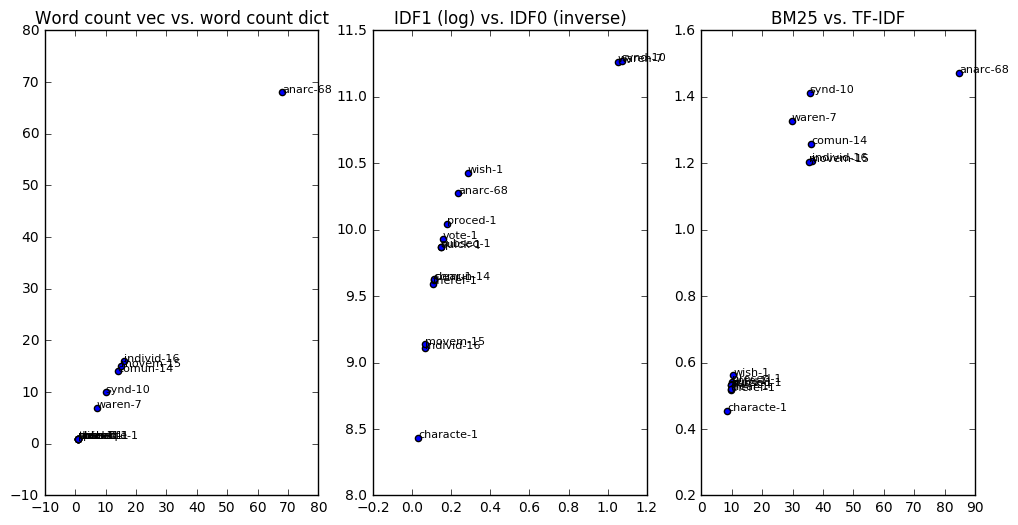

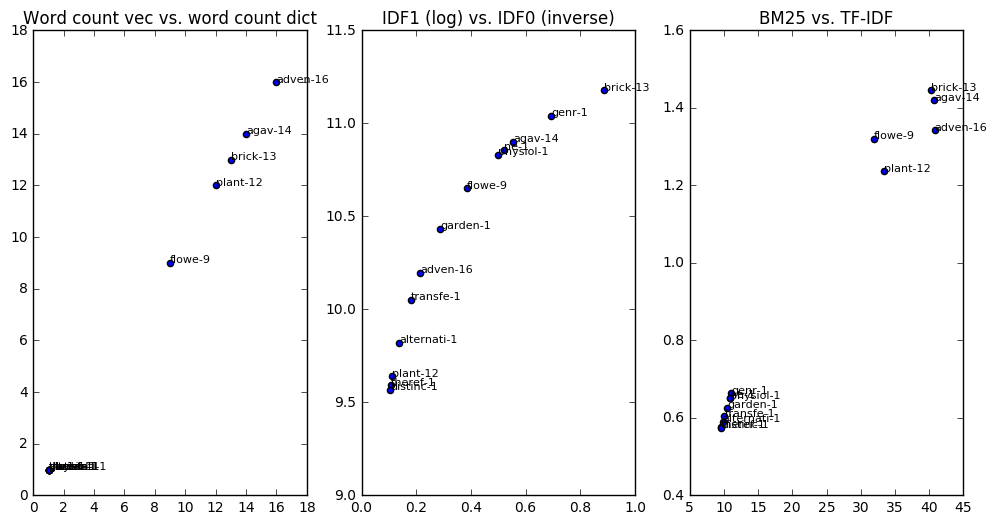

In [20]:
reload(plot)

# compute BM25 vectors for each document (and normalize them)
# "word counts are scaled to decimals between 0 and 1"
# [https://deeplearning4j.org/deepautoencoder#topic-modeling--information-retrieval-ir]
bm25s = [weights.bm25_weight(v, idf1, median_docsize, B=0.5, K1=0.8) for v in wc_vecs]
print('first bm25 vec (pre normalization): {}\n'.format(stats_str(bm25s[0])))
bm25_normalizer = construct_bm25_normalizer(bm25s)
bm25s = [bm25_normalizer(v) for v in bm25s]

# assemble datasets
cut = int(NUM_DOCUMENTS * 0.95)
trdata = tfidf.DataSet(bm25s[:cut], wcs[:cut], vocab)
vadata = tfidf.DataSet(bm25s[cut:], wcs[cut:], vocab)

first = trdata._df[:1].as_matrix().reshape((-1))
# set dfmt='{}' to avoid this error "TypeError: non-empty format string passed to object.__format__"
print('first bm25 vec (post normalization): {}\n'.format(stats_str(first)))

bm25sums = np.array([sum(v) for v in bm25s])
#print('bm25sums: {}'.format(stats_str(bm25sums)))  # TODO
mean_x_sum = np.mean(bm25sums)

for i in [0, NUM_DOCUMENTS-1]:
    plot.plot_document(vocab, idf0, idf1, wc_vecs[i], wcs[i], weights.tfidf_weight(wc_vecs[i], idf1), bm25s[i])

## Dimensionality Reduction

The dimensionality of latent space, `nz` in the next cell, can be thought of as the number of clusters that the input is being compressed down in to.  In other words, the compression ratio is `VOCAB_MAGNITUDE/nz`.  Another way to accomplish similar such clustering would be by the k-means algorithm with exactly that same number, `nz`, of clusters.  It could even be done hierarchically, analogously to the network architecture being used below, by first setting k=`nh1` then re-clustering each of those with k=`nh2/nh1` (or something like that).

The advantage of using an autoencoder is that the function space can be more continuous and less piecewise.

This informs the purpose of stemming.  Stemming isn't meant to convert all words of similar meaning to the same word.  Indeed it's not meant to do anything semantic; that's what the autoencoder is for.  It's only meant to reduce the dimensionality by a little so that the autoencoder has a good input representation to chew on.

TODO: After encoding run k-means clustering to deterime representative values for each of the clusters.  Encoding seems to separate points in space but it doesn't do so in a way s.t. you end up with 1-hot vectors.  k-means clustering is a way to transform or rotate axes (perhaps) that converts back to 1-hot and from there representative samples (or *explanations*) can be assigned to each bit of the 1-hot.

In [22]:
reload(vae)
reload(train)

# the original MNIST notebook uses 500/500/20 for these values
nh1 = int(VOCAB_MAGNITUDE/2) #600 #int(vmag/10)  # 1/10 of n_input? as suggested here: https://hal.inria.fr/hal-01256422v1/document
nh2 = int(VOCAB_MAGNITUDE/4) #400 # int(vmag/12)  # 1/12 of n_input? as suggested in same paper (except that this is their central layer!)
nz  = int(VOCAB_MAGNITUDE/6) #50  # 20? or was it 200? suggested by same paper?

netarch = {'n_input':VOCAB_MAGNITUDE, # number of items (1m=3706, 100k=1682)
           'n_hidden_recog_1':nh1, # 1st layer encoder neurons
           'n_hidden_recog_2':nh2, # 2nd layer encoder neurons
           'n_z':nz,               # dimensionality of latent space
           'n_hidden_gener_1':nh2, # 1st layer decoder neurons
           'n_hidden_gener_2':nh1} # 2nd layer decoder neurons

# weights higher input values more (by 1+a*x) in loss fn
confidence_alpha = VOCAB_MAGNITUDE / MEAN_DOC_SIZE * 10  # multiplying by 50 gets this near 1000 (as if the 0s don't even exist)
rmse_correction = 300 / confidence_alpha #/ mean_x_sum
batch_size = int(min(100, NUM_DOCUMENTS/2-1))
print('mean_x_sum = {}'.format(mean_x_sum))
print('confidence_alpha = {}'.format(confidence_alpha))
print('rmse_correction = {}'.format(rmse_correction))  # note that learning happens much faster at higher levels (similar to increasing learning_rate)
print('NORM_STRATEGY = {}'.format(NORM_STRATEGY.name))

# some expectations:
# 1. loss/cost should start around 200-300 and drop steadily over the epochs (if not, adjust `rmse_correction`)
# 2. the denoising loss should be a little higher than the corruption level (e.g. 38% vs. 0.3)
# 3. the latent loss should, at first, be optimized away, but then grow as the model switches to
#     focusing on reducing reconstruction loss
# 4. if learning isn't happening (i.e. loss dropping) then the normalization could be wrong (e.g. values not
#     approximately between 0 and 1)
untrained_vae = vae.VariationalAutoencoder(netarch,
                                           learning_rate=0.001,
                                           corruption_level=0.3,  ### this will fail w/ crossmaxent if vals > 1
                                           use_rmse=True,  ##########  use_rmse=False  #############
                                           rmse_correction=rmse_correction,
                                           confidence_alpha=confidence_alpha)

print('batch_size = {}'.format(batch_size))
print('NUM_EPOCHS = {}'.format(NUM_EPOCHS))
trained_vae = train.train(untrained_vae, trdata, vadata, display_step=40,
                          training_epochs=NUM_EPOCHS, batch_size=batch_size,
                          rmse_points=[1.0])

# TODO: rather than pretraining with RBMs why couldn't a NN be pre-trained with a linear (or any other)
# method?  e.g. run k-means clustering and then "encode" the output of that into the structure of the
# NN?  it's like progressively dumbing down from GAN -> supervised -> unsupervised -> pretraining ->
# Xavier initialization -- each previous, more simple pre-step has to be done first, in order before
# the more complex steps.  why can't a linear (or other non-NN) model be one of those steps?

mean_x_sum = 181.35817777842826
confidence_alpha = 166.66666666666669
rmse_correction = 1.7999999999999998
NORM_STRATEGY = INDEX


/home/fred/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2017-04-21 12:36:11,456 : INFO : vabatch.shape = (10, 5000)
2017-04-21 12:36:11,457 : INFO : Training on 190 data points


batch_size = 99
NUM_EPOCHS = 100


2017-04-21 12:36:12,209 : INFO : Epoch: 001 cost/va=434.6/796.9 (50.7 +33.7 +312.11; d=7%) rmse/va=0.3264/0.6279
2017-04-21 12:36:12,209 : INFO :           [0.326, 0.121] avg=0.224 stdev=0.103
2017-04-21 12:36:12,808 : INFO : Epoch: 002 cost/va=407.0/314.2 (49.8 +32.6 +68.99; d=8%) rmse/va=0.3267/0.6251
2017-04-21 12:36:12,808 : INFO :           [0.327, 0.149] avg=0.238 stdev=0.089
2017-04-21 12:36:13,471 : INFO : Epoch: 003 cost/va=151.1/203.3 (45.8 +29.9 +17.53; d=19%) rmse/va=0.3162/0.6047
2017-04-21 12:36:13,472 : INFO :           [0.316, 0.133] avg=0.225 stdev=0.091
2017-04-21 12:36:14,102 : INFO : Epoch: 004 cost/va=95.5/175.4 (45.7 +30.1 +6.28; d=31%) rmse/va=0.3015/0.5770
2017-04-21 12:36:14,103 : INFO :           [0.302, 0.156] avg=0.229 stdev=0.073
2017-04-21 12:36:14,697 : INFO : Epoch: 005 cost/va=82.5/167.7 (46.0 +30.1 +2.92; d=36%) rmse/va=0.2927/0.5624
2017-04-21 12:36:14,698 : INFO :           [0.293, 0.165] avg=0.229 stdev=0.064
2017-04-21 12:36:15,262 : INFO : Epoch: 

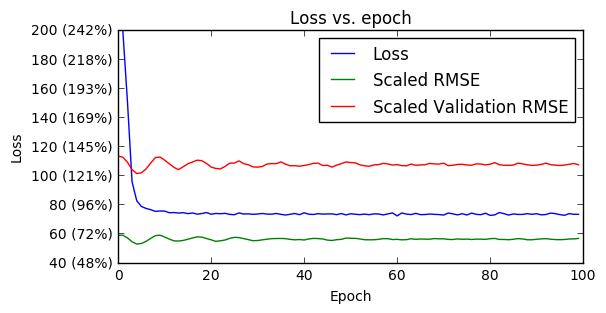

In [23]:
#trained_vae = untrained_vae

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.set_title('Loss vs. epoch')

y = np.clip(trained_vae.epoch_loss, 0, 200)
x = list(range(len(y)))
ax.plot(x, y, label='Loss')
ax.plot(x, np.array(trained_vae.epoch_rmse) * rmse_correction * 100, label='Scaled RMSE')
ax.plot(x, np.array(trained_vae.epoch_varmse) * rmse_correction * 100, label='Scaled Validation RMSE')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend()

rel = nth_largest(y, n=5)

# http://stackoverflow.com/questions/11244514/modify-tick-label-text
fig.canvas.draw()
labels = ['{} ({}%)'.format(k.get_text(), int(float(k.get_text()) / rel * 100)) for k in ax.get_yticklabels()]
ax.set_yticklabels(labels);

### TODO: It's learning the low values really well, but the RMSE on the higher valued points, not so much.  Perhaps this is the time to switch to an implicit model with each error weighted by a confidence.
* Actually, around epoch 900 it's starting to focus more on the higher points, and at 1200 the RMSE on the lower points is actually ticking up a little in favor of the higher points.  I.e. SELECTION BIAS is the root of all evil.

## On the next cell:

#### On the bm25 input vector:
The next cell shows `mean(argmax_qbm25s)` which is a measure of how well the individual query words are accounted for in the bm25 vector.  The bm25 vector can be thought of as having a similar meaning to a word count vector, but if a query word isn't in the vocabulary (e.g. if using softhots in place of wordcounts) then its argmax in the bm25 vector won't be very high.  This is why the stemmer helps--because it gets more non-stemmed words effectively included in the vocabulary; i.e. the more coverage the vocabulary has, the better.

#### On the reconstructions:
It also shows that reconstruction is somewhat selecting for common query words.  Argmax reconstruction words are "two" and "three."  Perhaps the reconstructions need to be adjusted for common words similar to how IDF is used to adjust the input vectors?  This would neutralize away words common words like "two" and "three" perhaps.

In [24]:
from collections import defaultdict

# even though 'anarchism' isn't in vocab, it still gets picked up by its Levenshtein
# proximity to 'analysis' which is in the vocabulary (but w/ stemming this works even
# better because 'anarch' is in the vocabulary => the more coverage the vocabulary has,
# the better)
query = 'international shipping'#'washington'#'anarchism originated term abuse'
stemmed_query = []
for w in query.split():
    stemmed_query.append(stemmer.stem(w))
stemmed_query = ' '.join(stemmed_query)
print('query = "{}"'.format(query))
print('stemmed_query = "{}"'.format(stemmed_query))

qwc = defaultdict(lambda: 0)
for w in stemmed_query.split():
    qwc[w] += 1
print('query word counts: {}'.format(dict(qwc)))
print('{}\n'.format(doctext2stopcount(query)[1:]))

qsh = word_count_vectorizer.aggregate(qwc)

# before and after normalization
#qtfidf = tfidf_weight(qsh, idf1)
qbm25 = weights.bm25_weight(qsh, idf1, median_docsize, B=0.5, K1=0.8)
print('Query bm25 before normalization:\n    {}'.format(stats_str(qbm25)))
qbm25 = bm25_normalizer(qbm25)  # must do this before sending through trained_vae.transform
print('Query bm25 after normalization:\n    {}'.format(stats_str(qbm25)))
#plot_document(qsh, qwc, qtfidf, qbm25)

qxform = trained_vae.transform(np.array([qbm25]))
qgen = trained_vae.generate(qxform)[0]
print('Reconstructed query bm25:\n    {}\n'.format(stats_str(qgen)))

print('NOTE CHANGE IN SKEW (from 27 to 0).  I.e. need to incorporate 0s into VAE loss function. \
 Or maybe not so much: we\'re applying the VAE to a query, not a document, for which it hasn\'t\
 been trained.  I suppose the skew should drop, but by how much?\n')
# conf = trained_vae.evaluate(trained_vae._confidence, np.array([qbm25]), np.array([qgen]))
# gt1 = np.where(conf > 1)
# print('confidences: {}\n'.format({w: c for w, c in zip([vocab[i] for i in gt1[0]], conf[gt1])}))

# argmax for each query word (so that we can view other words that we might inadvertently be
# selecting for), for example query="anarchism originated term abuse" gets converted into
# qargmaxs="analysis original term use" ... [update] but with a stemmer it gets converted to
# qargmaxs = "anarch origin term abus" (woohoo!)
qargmaxs = []
gargmaxs = []
argmax_qbm25s = []
for w in stemmed_query.split():

    # choose the argmax softhot for each word (can't use the qbm25 vector here b/c it's
    # already aggregated for the whole query...)
    wc_vec = word_count_vectorizer.eval(w)
    mx = np.max(wc_vec)
    i = np.argmax(wc_vec)  # when using wordcounts (as opposed to softhots) this is just the vocab index
    assert(i == vocab.index(w))  # won't necessarily be true for softhots (especially if OOV)
    argmax_qbm25s.append(qbm25[i])  # (... but we can select each word's corresponding bm25 given the argmax)
                            # (... and we can select each word's corresponding reconstruction given the argmax)

    qargmaxs.append('{}({:.2f}->{:.2f}->{:.2f})'.format(vocab[i], mx, qbm25[i], qgen[i]))

    # deterministically reconstruct (i.e. don't use vae.reconstruct) each word separately
    bm25 = weights.bm25_weight(wc_vec, idf1, median_docsize, B=0.5, K1=0.8)
    bm25 = bm25_normalizer(bm25)
    xform = trained_vae.transform(np.array([bm25]))
    gen = trained_vae.generate(xform)[0]
    mx_g = np.max(gen)
    i_g = np.argmax(gen)
    gargmaxs.append('{}({:.2f}->{:.2f})'.format(vocab[i_g], qbm25[i_g], mx_g))

qargmaxs = ' '.join(qargmaxs)
print('vocab argmax for each query word (wordcount/softhot->bm25->reconstructed):\n    {}'.format(qargmaxs))
print('        mean(argmax_qbm25s) = {:.2f} (see markdown note above on this metric)\n'.format(np.mean(argmax_qbm25s)))
print('vocab argmax for each RECONSTRUCTED query word:\n    {}\n'.format(gargmaxs))
print('If all the reconstructed argmax words are similar, then the VAE is just learning to pick\
 the words that occur in the most documents.  Perhaps better sampling is required in that case. \
 For example: sample words in inverse proportion to their frequencies by computing an average\
 inverse frequency for each document and then sampling documents in proportion to that (TODO).\n')

gargnths = []
top = 20
print('Top {}+ reconstructed query words:'.format(top))
n = 1
while n <= top:
    val = nth_largest(qgen, n=n)
    argnths = np.where(qgen == val)[0]
    for argnth in argnths:
        gargnths.append(vocab[argnth])
        print('    {}. {} ({:.2f})'.format(n, vocab[argnth], qgen[argnth]))
        n += 1
gargnths = ' '.join(gargnths)

query = "international shipping"
stemmed_query = "internat ship"
query word counts: {'internat': 1, 'ship': 1}
international/internat//7703 shipping/ship//3392

Query bm25 before normalization:
    mean=0.005, stdev=0.232, skew=50.107, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/0.000/0.000, 26th largest=11.100, max=12.093, argmax="ship"
Query bm25 after normalization:
    mean=0.000, stdev=0.021, skew=50.107, 25th/median/75th/95th/99.5th percentiles=0.000/0.000/0.000/0.000/0.000, 26th largest=1.000, max=1.089, argmax="ship"
Reconstructed query bm25:
    mean=0.574, stdev=0.245, skew=-1.012, 25th/median/75th/95th/99.5th percentiles=0.464/0.654/0.741/0.856/0.992, 26th largest=0.997, max=0.998, argmax="alask"

NOTE CHANGE IN SKEW (from 27 to 0).  I.e. need to incorporate 0s into VAE loss function.  Or maybe not so much: we're applying the VAE to a query, not a document, for which it hasn't been trained.  I suppose the skew should drop, but by how much?

vocab argmax for ea

## Comparison in Input Space (i.e. no autoencoder)
* This comparison should be weighted more heavily for queries containing OOV words (perhaps).

In [25]:
from tfae.nlputils import summarize
reload(summarize)
summarize.summarize_similar_docs(vocab, dts, bm25s, stemmed_query, qargmaxs, gargnths, qbm25, stemmer=stemmer)
# comparison in input-space

query = "internat ship"
qargmaxs = "internat(1.00->1.00->0.79) ship(1.00->1.09->0.75)"

closest docs = [(0.90605859498813168, 169), (0.91224173367533656, 168), (0.91657462023642022, 142), (0.91861827243239591, 66), (0.91955120328598117, 104), (0.92079286213432865, 143), (0.92484368849321974, 25), (0.92502076743493078, 193), (0.92817899914382529, 42), (0.9292736580357055, 106)]

furthest docs = [(1.0, 198), (1.0, 199)]

corrwords[169] = [(1.1, 1.1, 1.0, 'ship'), (0.7, 1.0, 0.7, 'internat'), (0.0, 0.0, 1.5, 'anchor'), (0.0, 0.0, 1.4, 'alask'), (0.0, 0.0, 1.3, 'railr'), (0.0, 0.0, 1.2, 'trail'), (0.0, 0.0, 1.2, 'flowe'), (0.0, 0.0, 1.2, 'bask'), (0.0, 0.0, 1.2, 'baseb'), (0.0, 0.0, 1.1, 'populati'), (0.0, 0.0, 1.1, 'park'), (0.0, 0.0, 1.1, 'hang'), (0.0, 0.0, 1.1, 'growt'), (0.0, 0.0, 1.1, 'gold'), (0.0, 0.0, 1.1, 'estab')]

doctext[169] = " of alaska it is also a census area with two six zero two eight three residents according to the two zero zero zero census anchorage is the largest ci

## Comparison in Latent Space (i.e. reduced dimensionality; middle layer of the autoencoder)
* For queries with all of their words in the vocabulary, this comparison should yield semantically similar documents.

In [26]:
reload(summarize)
#reload(vae) # by itself, this doesn't do anything b/c trained_vae is already of the given type
#type(trained_vae).transform = vae.VariationalAutoencoder.transform
xforms = trained_vae.transform(np.array(bm25s))
qxform = trained_vae.transform(np.array([qbm25]))
#am_xform = trained_vae.transform(np.array([am_bm25]))
summarize.summarize_similar_docs(vocab, dts, xforms, stemmed_query, qargmaxs, gargnths, qxform, simthresh=0.4, generator=trained_vae, stemmer=stemmer)
# comparison in latent-space

query = "internat ship"
qargmaxs = "internat(1.00->1.00->0.79) ship(1.00->1.09->0.75)"

closest docs = [(0.019508686771176897, 20), (0.02615335789072093, 33), (0.031047485209638181, 183), (0.03315411199479823, 42), (0.039407817627080455, 140), (0.040156526321451169, 185), (0.043896400503254274, 25), (0.046835565944009838, 41), (0.048039654347042049, 66), (0.048046152106950513, 167)]

furthest docs = [(0.2467304131425635, 113), (0.27478114401511844, 24)]

corrwords[20] = [(1.0, 1.0, 1.0, 'troi'), (1.0, 1.0, 1.0, 'teni'), (1.0, 1.0, 1.0, 'surv'), (1.0, 1.0, 1.0, 'spacec'), (1.0, 1.0, 1.0, 'slave'), (1.0, 1.0, 1.0, 'secti'), (1.0, 1.0, 1.0, 'rand'), (1.0, 1.0, 1.0, 'railr'), (1.0, 1.0, 1.0, 'plato'), (1.0, 1.0, 1.0, 'pig'), (1.0, 1.0, 1.0, 'orbit'), (1.0, 1.0, 1.0, 'objectiv'), (1.0, 1.0, 1.0, 'nasa'), (1.0, 1.0, 1.0, 'napole'), (1.0, 1.0, 1.0, 'mon')]

doctext[20] = " a lasting image of the danger of disunion due to slavery and rallied republicans across the north the one eight five eigh

## Comparison in Reconstruction Space (i.e. final layer of the autoencoder)
* Unsure how to interpret these comparisons.  Is there any reason to think they might be better than the latent-space ones?  One reason might be that they're more interpretable because specific corr words can be viewed (but latent-space corr words could be viewed also merely by converting the selected document reprs to reconstruction-space!).

In [27]:
gens = trained_vae.generate(xforms)
qgen = trained_vae.generate(qxform)[0]
#am_gen = trained_vae.generate(am_xform)[0]

# may want to use `bm25s` rather than `gens` here because we're interested in "semantically
# reconstructed documents" those which are semantically similar to the original query, not to
# the semantically transformed query ... but ... don't we want to semanticasize the query also
# then because an un-semanticasized query will contain words that are not found perhaps in
# semantic-space
summarize.summarize_similar_docs(vocab, dts, gens, stemmed_query, qargmaxs, gargnths, qgen, simthresh=0.5, stemmer=stemmer)
print('###############################################################################\n')
summarize.summarize_similar_docs(vocab, dts, bm25s, stemmed_query, qargmaxs, gargnths, qgen, simthresh=0.5, stemmer=stemmer)
# comparison in (re)generated/output-space

query = "internat ship"
qargmaxs = "internat(1.00->1.00->0.79) ship(1.00->1.09->0.75)"

closest docs = [(-5.8225091859043232e-08, 159), (-5.773078171067425e-08, 104), (-5.354928322987007e-08, 78), (-5.2256781346571302e-08, 76), (-5.081222687053355e-08, 117), (-5.0013896579770289e-08, 161), (-4.2259032495550741e-08, 182), (-3.534006687289093e-08, 51), (-3.4199975962323492e-08, 139), (-3.0170434150988967e-08, 5)]

furthest docs = [(1.4150648286470613e-07, 113), (1.4707308093608873e-07, 30)]

corrwords[159] = [(1.0, 1.0, 1.0, 'troi'), (1.0, 1.0, 1.0, 'teni'), (1.0, 1.0, 1.0, 'surv'), (1.0, 1.0, 1.0, 'spacec'), (1.0, 1.0, 1.0, 'slave'), (1.0, 1.0, 1.0, 'secti'), (1.0, 1.0, 1.0, 'rand'), (1.0, 1.0, 1.0, 'railr'), (1.0, 1.0, 1.0, 'plato'), (1.0, 1.0, 1.0, 'pig'), (1.0, 1.0, 1.0, 'orbit'), (1.0, 1.0, 1.0, 'objectiv'), (1.0, 1.0, 1.0, 'nasa'), (1.0, 1.0, 1.0, 'napole'), (1.0, 1.0, 1.0, 'mon')]

doctext[159] = " chains are usually between twenty and thirty carbon atoms in length and are made by

In [ ]:
logging.info('end')